In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import lightkurve as lk
import astropy as ap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


# === STEP 1: LOAD DATASET AND LABELS ===
df = pd.read_csv("nuFullSet2.csv")
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

x = []
y = []

kepid = 11768142
lc = lk.read("lightcurves_fits2/" + str(kepid) +".fits")
lc.plot()

period, t0, duration_hours = 8.88492, 134.452, 2.078

lc_clean = lc.remove_outliers(sigma=20, sigma_upper=4)
lc_clean.plot()

row = df.loc[df["kepid"] == kepid]
planet_period = row.iloc[0]["koi_period"]
planet_t0 = row.iloc[0]["koi_time0bk"]
planet_dur = row.iloc[0]["koi_duration"]

period = planet_period
t0 = planet_t0
duration_hours = planet_dur

print(period,t0,duration_hours)

temp_fold = lc_clean.fold(period, epoch_time=t0)
fractional_duration = (duration_hours / 24.0) / period
phase_mask = np.abs(temp_fold.phase) < (fractional_duration * 1.5)
transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])

lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)

lc_fold = lc_flat.fold(period, epoch_time=t0)
lc_fold.scatter()

lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1
lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
# lc_global.flux.shape

lc_global.scatter()

num = 10.0
phase_mask = (lc_fold.phase > -num*fractional_duration) & (lc_fold.phase < num*fractional_duration)
lc_zoom = lc_fold[phase_mask]

# lc_zoom.scatter()

lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1
# lc_local.flux.shape

print(len(lc_local.flux))

lc_local.scatter()

100

18421


C:\Users\jarvi\AppData\Local\Temp\ipykernel_28460\4166864120.py:25: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  binned_lc = folded_lc.bin(binsize=5)


1111


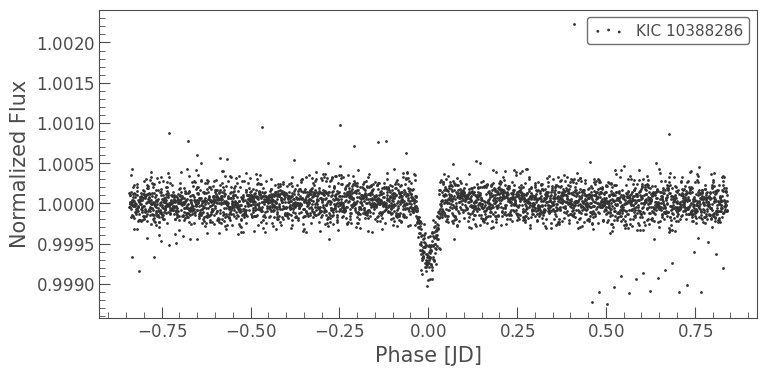

In [ ]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

kepid = 10360722
df = pd.read_csv("nuSet.csv")

row = df.loc[df["kepid"] == kepid]
period = row.iloc[0]["koi_period"]
t0 = row.iloc[0]["koi_time0bk"]
dur = row.iloc[0]["koi_duration"]

# test with KIC 757450
lc = lk.search_lightcurve("KIC " + str(kepid), mission="Kepler", cadence = "long", limit = 5).download_all().stitch()
lc = lc.normalize().remove_nans().remove_outliers().flatten()
print(lc.flux.unit)
folded_lc = lc.fold(period=period, epoch_time=t0)  # using koi_period, koi_time0bk
# folded_lc.scatter()

# folded_lc.scatter()
print(len(folded_lc.flux))

binned_lc = folded_lc.bin(binsize=5)
binned_lc.scatter()

# Example: time and flux from a stitched light curve
time = binned_lc.time.value  # assuming lc is a LightCurve object
flux = binned_lc.flux.value

def crop_lightcurve_by_duration(time, flux, t0, duration_hours, factor=3):
    # Convert duration to days
    duration_days = duration_hours / 24

    # Total window size = duration * factor on each side
    window_days = duration_days * factor

    # Find the index closest to t0 (mid-transit)
    mid_index = np.argmin(flux)

    # Get actual time at min flux or t0
    mid_time = time[mid_index]

    # Get start and end times
    start_time = mid_time - window_days
    end_time = mid_time + window_days

    # Mask the data within that window
    mask = (time >= start_time) & (time <= end_time)
    cropped_time = time[mask]
    cropped_flux = flux[mask]

    return cropped_time, cropped_flux

cropped_time, cropped_flux = crop_lightcurve_by_duration(time, flux, dur,4)
print(len(cropped_flux))

# # Step 4: Plot to verify
# plt.scatter(cropped_time, cropped_flux)
# plt.xlabel("Phase")
# plt.ylabel("Normalized Flux")
# plt.title("Cropped Transit Window")
# plt.show()

In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import lightkurve as lk
import astropy as ap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


# === STEP 1: LOAD DATASET AND LABELS ===
# df = pd.read_csv("nuFullSet2.csv")
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

x = []
y = []

kepid = 757450

# Search and download light curves
search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5, author = "Kepler")
lc_collection = search_result.download_all()

lc = lc_collection.stitch()
# lc.plot()

period, t0, duration_hours = 8.88492, 134.452, 2.078

lc_clean = lc.remove_outliers(sigma=20, sigma_upper=4)
# lc_clean.plot()

temp_fold = lc_clean.fold(period, epoch_time=t0)
fractional_duration = (duration_hours / 24.0) / period
phase_mask = np.abs(temp_fold.phase) < (fractional_duration * 1.5)
transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])

lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)

lc_fold = lc_flat.fold(period, epoch_time=t0)
lc_fold.scatter()

lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1
lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
# lc_global.flux.shape

lc_global.scatter()

phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
lc_zoom = lc_fold[phase_mask]

# lc_zoom.scatter()

lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1
# lc_local.flux.shape

print(len(lc_local.flux))

lc_local.scatter()

In [ ]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd

# Step 1: Query CONFIRMED KOIs
confirmed = NasaExoplanetArchive.query_criteria(
    table="q1_q17_dr25_koi",
    select="kepid, koi_period, koi_time0bk, koi_duration, koi_disposition",  # Only kepid and koi_disposition
    where="koi_disposition = 'CONFIRMED'"
).to_pandas().dropna()

# Step 2: Query FALSE POSITIVE KOIs
false_positives = NasaExoplanetArchive.query_criteria(
    table="q1_q17_dr25_koi",
    select="kepid, koi_period, koi_time0bk, koi_duration, koi_disposition",  # Only kepid and koi_disposition
    where="koi_disposition = 'FALSE POSITIVE'"
).to_pandas().dropna()

# Step 3: Keep only one KOI per star (shortest period)
confirmed_unique = confirmed.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")
false_unique = false_positives.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")

# Step 4: Remove overlapping kepids (same star in both groups)
overlap_kepids = set(confirmed_unique['kepid']).intersection(set(false_unique['kepid']))
# print(f"Number of overlapping kepids: {len(overlap_kepids)}")

confirmed_clean = confirmed_unique[~confirmed_unique['kepid'].isin(overlap_kepids)]
false_clean = false_unique[~false_unique['kepid'].isin(overlap_kepids)]

# Step 5: Sample 1000 unique stars from each class
confirmed_sample = confirmed_clean.sample(n=50, random_state=42)
false_sample = false_clean.sample(n=50, random_state=42)

# Step 6: Combine and shuffle
balanced_df = pd.concat([confirmed_sample, false_sample], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save to CSV
balanced_df.to_csv("nuFullSet2.csv", index=False)

# Final check
print(f"Final dataset size: {len(balanced_df)} rows")
print(f"Unique stars (kepid): {balanced_df['kepid'].nunique()}")
print(balanced_df.head())

In [130]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd


where_con = (
    "koi_disposition = 'CONFIRMED' AND "
    "koi_depth > 200 AND "
    "koi_model_snr > 15 AND "
    "koi_fpflag_nt = 0 AND "
    "koi_fpflag_ss = 0 AND "
    "koi_fpflag_co = 0 AND "
    "koi_fpflag_ec = 0"
)

where_fal = (
    "koi_disposition = 'FALSE POSITIVE' AND "
    "koi_fpflag_nt = 1"
)

# Step 1: Query CONFIRMED KOIs
confirmed = NasaExoplanetArchive.query_criteria(
    table="cumulative",
    select="kepid, koi_period, koi_duration, koi_time0bk, koi_disposition",
    where=where_con
).to_pandas().dropna()

confirmed.head()

# Step 2: Query FALSE POSITIVE KOIs
false_positives = NasaExoplanetArchive.query_criteria(
    table="cumulative",
    select="kepid, koi_period, koi_duration, koi_time0bk, koi_disposition",
    where = where_fal
).to_pandas().dropna()

# Step 3: Keep only one KOI per star (shortest period)
confirmed_unique = confirmed.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")
false_unique = false_positives.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")

# Step 4: Remove overlapping kepids (same star in both groups)
overlap_kepids = set(confirmed_unique['kepid']).intersection(set(false_unique['kepid']))
# print(f"Number of overlapping kepids: {len(overlap_kepids)}")

confirmed_clean = confirmed_unique[~confirmed_unique['kepid'].isin(overlap_kepids)]
false_clean = false_unique[~false_unique['kepid'].isin(overlap_kepids)]

# Step 5: Sample 1000 unique stars from each class
confirmed_sample = confirmed_clean.sample(n=50, random_state=42)
false_sample = false_clean.sample(n=50, random_state=42)

# Step 6: Combine and shuffle
balanced_df = pd.concat([confirmed_sample, false_sample], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save to CSV
balanced_df.to_csv("nuSet.csv", index=False)

# Final check
print(f"Final dataset size: {len(balanced_df)} rows")
print(f"Unique stars (kepid): {balanced_df['kepid'].nunique()}")
print(balanced_df.head())

Final dataset size: 100 rows
Unique stars (kepid): 100
     kepid  koi_period  koi_duration  koi_time0bk koi_disposition
0  6043574  381.782641        4.5200    241.12260  FALSE POSITIVE
1  4663658    0.705891        5.2810    131.62062  FALSE POSITIVE
2  8979500  113.556471        2.3830    186.23210  FALSE POSITIVE
3  2721030    6.100276        4.7476    135.58656       CONFIRMED
4  9957627   39.752992        4.9641    175.46244       CONFIRMED


In [ ]:
import pandas as pd
import lightkurve as lk
import os
import concurrent.futures
import warnings
from threading import Lock
from astropy.utils.exceptions import AstropyWarning

# === Suppress astropy unit warnings ===
warnings.simplefilter('ignore', category=AstropyWarning)

# === Load the dataset of KOIs ===
df = pd.read_csv("nuFullSet2.csv")  # Make sure this matches your file
kepids = df["kepid"].unique().tolist()

# === Directory to save light curves ===
save_dir = "lightcurves_fits2"
os.makedirs(save_dir, exist_ok=True)

# === Create a lock for thread-safe file saving ===
save_lock = Lock()

# === Function to download and save light curve ===
def download_and_save_lightcurve(kepid):
    try:
        filepath = os.path.join(save_dir, str(kepid) + ".fits")

        # Skip if file already exists
        if os.path.exists(filepath):
            return f"Skipped {kepid} (already exists)"

        # Search and download light curves
        search_result = lk.search_lightcurve(f"KIC{kepid}", limit = 5, author = "Kepler")
        lc_collection = search_result.download_all()
        print("Downloaded: " + str(kepid))
        if lc_collection is None:
            return f"No data for {kepid}"
        
        stitched_lc = lc_collection.stitch()

        # Save safely using a lock
        with save_lock:
            stitched_lc.to_fits(filepath)

        return f"Downloaded {kepid}"

    except Exception as e:
        return f"Error with {kepid}: {e}"

# # === Multithreaded download ===
# results = []
# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     futures = [executor.submit(download_and_save_lightcurve, kepid) for kepid in kepids]
#     for future in concurrent.futures.as_completed(futures):
#         result = future.result()
#         results.append(result)
#         print(result)

# # === Save download log ===
# with open("download_log.txt", "w") as log_file:
#     for line in results:
#         log_file.write(f"{line}\n")

i = 1
for kepid in kepids:
    download_and_save_lightcurve(kepid)
    print(i)
    i+=1